In [270]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2)
from time import time


In [ ]:

X = np.linspace(0,10,20)[:,None]
Xlocs = X.copy()
X = np.c_[X,np.zeros(X.shape[0])]
X = np.r_[X,X]
#X[:int(len(X)/2),0]*=2
X[int(len(X)/2):,1]=1

y = 10*(1+np.cos(Xlocs/2))
X = tf.Variable(X,dtype=tf.float32)
Z = X[::2,:]
Z = tf.Variable(Z,dtype=tf.float32)
y = tf.Variable(y,dtype=tf.float32)
m = Z.shape[0]

In [260]:
def newK(X1,X2):
    cov = np.zeros([X1.shape[0],X2.shape[0]])
    for i1,x1 in enumerate(X1.numpy()):
        for i2,x2 in enumerate(X2.numpy()):
            if x1[-1]==x2[-1]:
                cov[i1,i2]=0.01*tf.exp(-tf.math.reduce_sum(x1[:-1]-x2[:-1])**2/(2*1**2))
    return tf.Variable(cov,dtype=np.float32)

def K(X1,X2):
    return 1*tf.cast(tf.math.equal(X1[:,-1,None],X2[None,:,-1]),tf.float32)*tf.exp(-tf.math.reduce_sum(tf.subtract(X1[:,None],X2[None,:])**2/(2*2**2),2)) 
    #return tf.exp(-tf.math.reduce_sum(tf.subtract(X1[:,None],X2[None,:])**2/(2*5**2),2)) 


In [261]:
with tf.GradientTape() as tape:
    a = K(Z,Z)
tape.gradient(a, [Z])

[<tf.Tensor: id=30624254, shape=(20, 2), dtype=float32, numpy=
 array([[ 1.856,  0.   ],
        [ 1.397,  0.   ],
        [ 0.792,  0.   ],
        [ 0.334,  0.   ],
        [ 0.082,  0.   ],
        [-0.082,  0.   ],
        [-0.334,  0.   ],
        [-0.792,  0.   ],
        [-1.397,  0.   ],
        [-1.856,  0.   ],
        [ 1.856,  0.   ],
        [ 1.397,  0.   ],
        [ 0.792,  0.   ],
        [ 0.334,  0.   ],
        [ 0.082,  0.   ],
        [-0.082,  0.   ],
        [-0.334,  0.   ],
        [-0.792,  0.   ],
        [-1.397,  0.   ],
        [-1.856,  0.   ]], dtype=float32)>]

In [262]:
#definition of q(u)
mu = tf.Variable(1+0.1*tf.random.normal([m]))#, name='mu')
scale = tf.Variable(0.1*tf.random.normal([m, m]))#, name='scale')

#parameters for p(u)
mu_u = tf.zeros([1,m])
cov_u = tf.Variable(K(Z,Z))

pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)


In [263]:
#dist = tfd.MultivariateNormalFullCovariance(tf.gather_nd(qf_mu,[[i,0],[i+20,0]]),tf.reshape(tf.gather_nd(qf_cov,[[i,i],[i,i+20],[i+20,i],[i+20,i+20]]),[2,2]))
#dist.sample(10)

In [264]:
def combine_sensor_latent(sens,lat):
    return tf.exp(sens)*lat

In [276]:
st = time()
for it in range(500):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        
        qf_mu = K(X,Z) @ invKzz @ mu[:,None]
        #need to solve in a numerically stable manner.
        #only need trace of this... TODO
        qf_cov = K(X,X) - K(X,Z) @ invKzz @ K(Z,X) + K(X,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,X)
      
        ell = 0
        for i in range(int(X.shape[0]/2)):
            dist = tfd.MultivariateNormalFullCovariance(tf.gather_nd(qf_mu,[[i,0],[i+20,0]]),tf.eye(2)*0.01+tf.reshape(tf.gather_nd(qf_cov,[[i,i],[i,i+20],[i+20,i],[i+20,i+20]]),[2,2]))
            samps = dist.sample(100)
            f = combine_sensor_latent(samps[:,1],samps[:,0]) #tf.exp(samps[:,1])*samps[:,0]
            if i<6:
                f = samps[:,0]
            ell+=tf.math.reduce_mean(tfd.Normal(f,0.01).log_prob(y[i]))
           
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
    gradients = tape.gradient(elbo_loss, [mu, scale])
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%5 == 0: print("%d %0.2f %0.4f %0.0f" % (it,time()-st,(time()-st)/(it+1),elbo_loss.numpy()))#,qf_mu[:,0].numpy(),mu.numpy())
                    

0 0.23 0.2291 1386771
5 1.37 0.2287 1400718
10 2.42 0.2202 1387869
15 3.47 0.2169 1372757
20 4.52 0.2153 1391972
25 5.56 0.2140 1412086
30 6.61 0.2132 1367445
35 7.70 0.2138 1365212
40 8.76 0.2138 1358872
45 9.81 0.2132 1380386
50 10.89 0.2135 1340640
55 11.94 0.2132 1376376
60 13.29 0.2178 1362378
65 14.33 0.2171 1386924
70 15.38 0.2166 1351727
75 16.46 0.2166 1335389
80 17.72 0.2187 1337456
85 18.87 0.2194 1354276
90 20.02 0.2200 1325557
95 21.15 0.2204 1363108
100 22.30 0.2208 1308428
105 23.41 0.2209 1334059
110 24.54 0.2210 1339837
115 25.70 0.2216 1366140
120 26.84 0.2218 1323838
125 27.93 0.2217 1334694
130 29.06 0.2219 1287037


KeyboardInterrupt: 

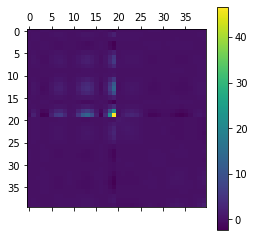

In [277]:
plt.matshow(qf_cov)
plt.colorbar()

In [278]:
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.01)

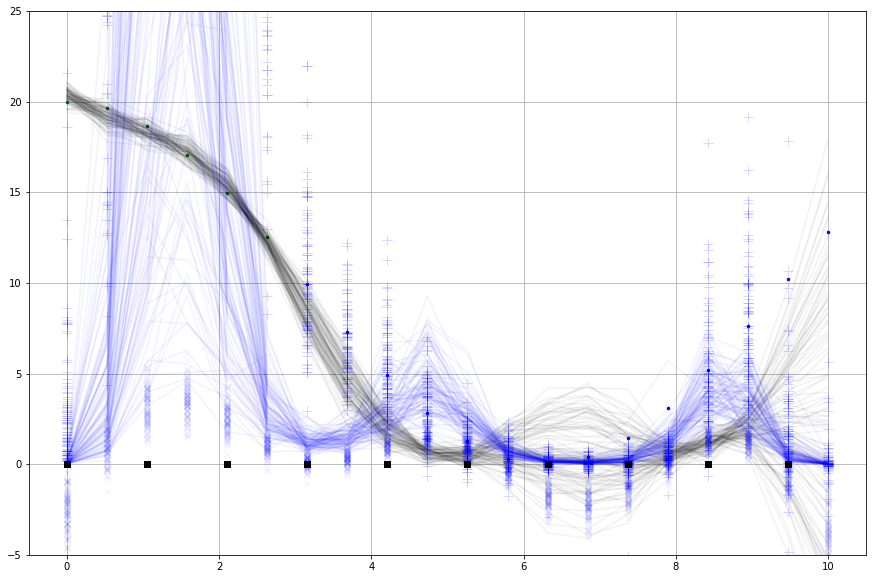

In [281]:
plt.figure(figsize=[15,10])
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.1)
samps = qf.sample([100]).numpy()
plt.plot(Xlocs[:6,:],y.numpy()[:6],'.g',markersize=5)
plt.plot(Xlocs[6:,:],y.numpy()[6:],'.b',markersize=5)
Xn = X.numpy()
plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==0].T,'k-',alpha=0.05);
plt.plot(Xn[Xn[:,1]==1,0],np.exp(samps[:,Xn[:,1]==1].T),'b-',alpha=0.05);
plt.plot(Xn[Xn[:,1]==0,0],tf.transpose(combine_sensor_latent(samps[:,Xn[:,1]==1],samps[:,Xn[:,1]==0])),'b+',markersize=10,alpha=0.15);
plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==1].T,'bx',alpha=0.05);
plt.ylim([-5,25])
#Xstar = np.linspace(-5,15,1000)[:,None]
#invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)

#mean = (K(Xstar,Z) @ invKzz @ mu.numpy()[:,None]).numpy()[:,0]
#cov = K(Xstar,Xstar) - K(Xstar,Z) @ np.linalg.inv(K(Z,Z)) @ K(Z,Xstar)
#stds = np.sqrt(np.diag(cov))

#plt.plot(Xstar,mean,'r-',lw=3);
#plt.plot(Xstar,mean+stds,'r-',lw=1);
#plt.plot(Xstar,mean-stds,'r-',lw=1);
plt.grid()
plt.plot(Z.numpy()[:,0],np.zeros_like(Z.numpy()),'ks')

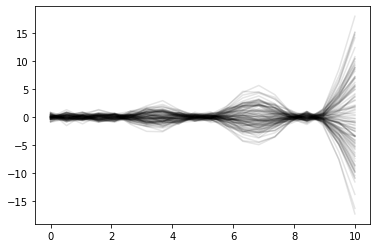

In [280]:
plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]-np.mean(samps[:,Xn[:,1]==0],0)).T,'k-',alpha=0.1);

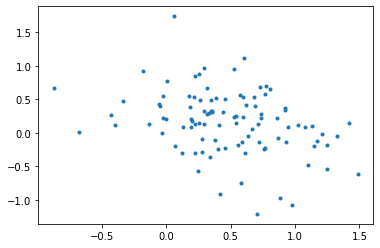

In [287]:
plt.plot(samps[:,15],samps[:,35],'.');